In [1]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt

from pathlib import Path
from airLibs import airfoil as af
from airLibs import runF2w as f2w
from airLibs import plotting as aplt
from airLibs import runOpenFoam as of

# Reynolds And Mach and AoA

In [2]:
def ms2mach(ms):
    return ms / 340.29

def Re(v, c, n):
    return (v * c) / n

In [3]:
chordMax = 0.18
chordMin = 0.11
umax = 30
umin = 5
ne = 1.56e-5

In [4]:
Machmin = ms2mach(10)
Machmax = ms2mach(30)
Remax = Re(umax, chordMax, ne)
Remin = Re(umin, chordMin, ne)
AoAmax = 15
AoAmin = -6
NoAoA = (AoAmax - AoAmin) * 2 + 1

In [5]:
angles = np.linspace(AoAmin, AoAmax, NoAoA)
Reynolds = np.logspace(np.log10(Remin), np.log10(Remax), 20, base=10)
Mach = np.linspace(Machmax, Machmin, 10)

Reyn = Remax
MACH = Machmax

In [6]:
CASE = "Wing"
os.chdir(CASE)
casedir = os.getcwd()
cleaning = True
calcF2W = True
calcOpenFoam = False
calcXFoil = False

# Get Airfoil

In [7]:
for i in os.listdir():
    if i.startswith("naca"):
        airfile = i
airfoil = airfile[4:]

# Generate Airfoil

(-0.05, 1.05, -0.049705262133265996, 0.12146125008203564)

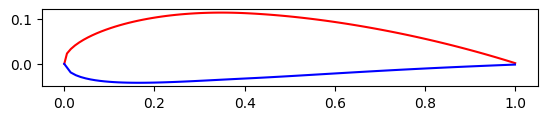

In [8]:
n_points = 100
pts = af.saveAirfoil(["s", airfile, airfoil, 0, n_points])
x, y = pts.T
plt.plot(x[: n_points ], y[: n_points], "r")
plt.plot(x[n_points:], y[n_points:], "b")

# plt.plot(x,y)
plt.axis("scaled")

# Foil2Wake

In [9]:
Ncrit = 9
ftrip_low = {"pos": 0.1, "neg": 0.2}
ftrip_up = {"pos": 0.1, "neg": 0.2}

if cleaning == True:
    f2w.removeResults(angles)
if calcF2W == True:
    clcd = f2w.runFw2(Reyn, MACH, ftrip_low, ftrip_up, angles, airfile)
clcdcmFW = f2w.makeCLCD(Reyn, MACH, angles)

rm: cannot remove 'SOLOUTI*': No such file or directory
rm: cannot remove 'PAKETO': No such file or directory
mkdir: cannot create directory '0.00000/': File exists
mkdir: cannot create directory '0.50000/': File exists
mkdir: cannot create directory '1.00000/': File exists
mkdir: cannot create directory '1.50000/': File exists
mkdir: cannot create directory '2.00000/': File exists
mkdir: cannot create directory '2.50000/': File exists
mkdir: cannot create directory '3.00000/': File exists
mkdir: cannot create directory '3.50000/': File exists
mkdir: cannot create directory '4.00000/': File exists
mkdir: cannot create directory '4.50000/': File exists
mkdir: cannot create directory '5.00000/': File exists
mkdir: cannot create directory '5.50000/': File exists
mkdir: cannot create directory '6.00000/': File exists
mkdir: cannot create directory '6.50000/': File exists
mkdir: cannot create directory '7.00000/': File exists
mkdir: cannot create directory '7.50000/': File exists
mkdir: can

OK


# Xfoil

In [ ]:
xf = XFoil()
xf.Re = Reyn
xf.max_iter = 100
xf.print = False
xpts, ypts = pts.T
naca0008 = XFAirfoil(x=xpts, y=ypts)
xf.airfoil = naca0008
aXF, clXF, cdXF, cmXF, cpXF = xf.aseq(AoAmin, AoAmax, 0.5)
# clcdcmXF = np.array([aXF, clXF, cdXF, cmXF]).T

# OpenFoam

In [ ]:
os.chdir(casedir)
maxITER = 10500
if calcOpenFoam == True:
    of.makeMesh(airfile)
    of.setupOpenFoam(Reyn, MACH, angles, silent=True, maxITER=maxITER)
    of.runFoam(angles)
# clcdcmOF = of.makeCLCD(angles)